# 🧠 Prédiction de la falsification de billets en euros

L’objectif de ce projet est de construire une application de Machine Learning permettant de détecter si un billet en euros est **vrai ou faux** à partir de ses caractéristiques physiques (longueur, hauteur, marges...).

Nous utilisons un jeu de données de 1500 billets (1000 vrais, 500 faux) fourni par l’ONCFM, en suivant leurs recommandations algorithmiques :

- Régression logistique
- KNN
- Random Forest
- K-Means (non supervisé)


In [24]:
# Importations

import sys
import os
sys.path.append(os.getcwd())
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from script import pipeline_global, afficher_matrice_confusion, predire_billet, completer_margin_low_par_regression



In [25]:
# Affichage de la matrice de confusion
df = pd.read_csv("billets.csv", sep=';')


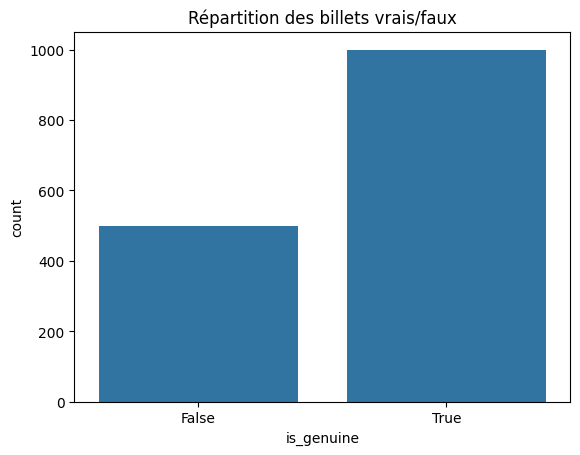

In [26]:
# Répartition vrai/faux
sns.countplot(data=df, x="is_genuine")
plt.title("Répartition des billets vrais/faux")
plt.show()

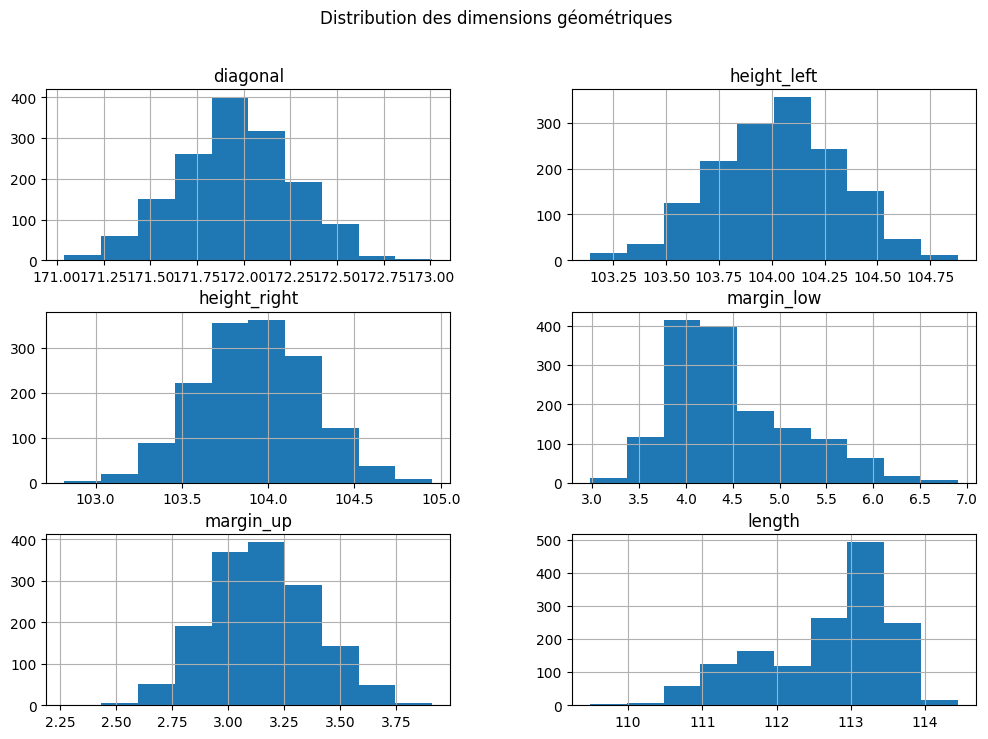

In [27]:
# Histogrammes des dimensions
df.hist(figsize=(12, 8))
plt.suptitle("Distribution des dimensions géométriques")
plt.show()


In [28]:
# Vérification des valeurs manquantes dans 'margin_low'
df_check = pd.read_csv("billets.csv", sep=';')
print("Valeurs manquantes dans 'margin_low' AVANT traitement :", df_check['margin_low'].isna().sum())

# Importer et appliquer la fonction d'imputation pour test
from script import completer_margin_low_par_regression
df_check = completer_margin_low_par_regression(df_check)
print("Valeurs manquantes dans 'margin_low' APRÈS traitement :", df_check['margin_low'].isna().sum())


Valeurs manquantes dans 'margin_low' AVANT traitement : 37
Valeurs manquantes dans 'margin_low' APRÈS traitement : 0


In [29]:
# Lance le traitement complet : nettoyage, entraînement, évaluation
best_model, scaler = pipeline_global()


Régression Logistique:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

KNN:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       100
           1       0.99      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.

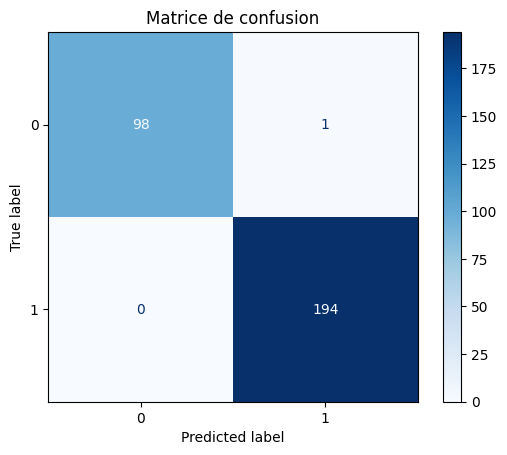

In [30]:
# Recharger le fichier (nécessaire car pipeline_global() utilise sa propre copie)
df = pd.read_csv("billets.csv", sep=';')
afficher_matrice_confusion(best_model, scaler, df)


## 🔍 Analyse des performances des modèles

Les résultats affichés par le pipeline montrent que :

- **Régression Logistique** : très bon score (≈ 99%)
- **KNN** : score légèrement inférieur mais bon
- **Random Forest** : aussi performant que la régression logistique, voire meilleur en généralisation
- **K-Means** : approche non supervisée avec une bonne approximation (≈ 98%)

---

### ✅ Modèle retenu : `Random Forest`  
Il a été retenu pour :
- Sa précision élevée
- Sa robustesse aux données bruitées
- Sa capacité à gérer les interactions entre variables


In [31]:
# Exemple : prédire un billet à partir de ses caractéristiques
nouveau_billet = {
    'diagonal': 172.0,
    'height_left': 104.0,
    'height_right': 104.2,
    'margin_low': 4.1,
    'margin_up': 3.0,
    'length': 113.0
}

resultat = predire_billet(best_model, scaler, nouveau_billet)
print("Résultat :", resultat)


Résultat : VRAI billet


## 🏁 Conclusion

Nous avons :
- Nettoyé et complété les données avec une régression linéaire multiple
- Entraîné 4 modèles (3 supervisés, 1 non supervisé)
- Comparé leurs performances
- Sélectionné le meilleur modèle (`Random Forest`)
- Créé une application simple de prédiction

🎉 Cette application peut désormais aider l’ONCFM à détecter automatiquement les faux billets à partir de caractéristiques physiques mesurées par scan.
